In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Mounted at /content/drive


In [2]:
# 2. Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/NVL Historical Data 1_6.csv')

In [3]:
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df=df[::-1]
df1=df.reset_index()['Price']

In [4]:
train_size = int(0.9 * len(df1))
test_size = int(len(df1)) - train_size

In [5]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [6]:
# 4. Chia train test


train_data = df1[:train_size]
test_data = df1[train_size:]

In [7]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [8]:

#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [9]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [10]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 5s 124ms/step - loss: 0.0637 - val_loss: 0.0356
Epoch 2/100
21/21 [==============================] - 2s 89ms/step - loss: 0.0078 - val_loss: 0.0044
Epoch 3/100
21/21 [==============================] - 1s 63ms/step - loss: 0.0018 - val_loss: 7.0607e-04
Epoch 4/100
21/21 [==============================] - 1s 53ms/step - loss: 4.7074e-04 - val_loss: 6.0209e-05
Epoch 5/100
21/21 [==============================] - 1s 52ms/step - loss: 3.8399e-04 - val_loss: 6.1953e-05
Epoch 6/100
21/21 [==============================] - 2s 78ms/step - loss: 3.6281e-04 - val_loss: 8.8875e-05
Epoch 7/100
21/21 [==============================] - 1s 54ms/step - loss: 3.4912e-04 - val_loss: 8.6036e-05
Epoch 8/100
21/21 [==============================] - 1s 54ms/step - loss: 3.3495e-04 - val_loss: 7.4404e-05
Epoch 9/100
21/21 [==============================] - 1s 52ms/step - loss: 3.2786e-04 - val_loss: 7.5388e-05
Epoch 10/100
21/21 [===========================

In [12]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

2/2 [==============================] - 0s 22ms/step


In [13]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [14]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 15946.265739293714


In [15]:
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_pred, ytest)
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))*100
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing MAPE: 99.9995666928735
Testing MAE: 15876.648081323994


In [16]:
x_input = test_data[len(test_data)-time_step:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

print(lst_output)


[[0.04891540855169296], [0.048565153032541275], [0.048100173473358154], [0.04760126397013664], [0.04708035662770271], [0.046540793031454086], [0.04598509892821312], [0.04541536420583725], [0.04483329504728317], [0.04424021393060684], [0.04363717511296272], [0.04302501305937767], [0.042404383420944214], [0.04177583009004593], [0.04113979637622833], [0.0404965877532959], [0.039846498519182205], [0.03918972983956337], [0.038526467978954315], [0.03785683214664459], [0.03718094900250435], [0.03649888187646866], [0.035810697823762894], [0.035116441547870636], [0.034416139125823975], [0.0337098091840744], [0.03299746662378311], [0.032279111444950104], [0.03155474364757538], [0.030824339017271996], [0.030087895691394806], [0.02934538759291172], [0.028596797958016396], [0.027842100709676743], [0.027081279084086418], [0.026314295828342438], [0.025541115552186966], [0.02476172335445881], [0.023976076394319534], [0.023184143006801605], [0.022385891526937485], [0.021581286564469337], [0.02077029831

In [17]:
future_predict = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
future_predict

array([[14266.73768863],
       [14237.97610642],
       [14199.79384494],
       [14158.82539217],
       [14116.05056484],
       [14071.74376057],
       [14026.11238359],
       [13979.32804713],
       [13931.5308561 ],
       [13882.82940713],
       [13833.31027158],
       [13783.04197238],
       [13732.07834899],
       [13680.46406367],
       [13628.23551923],
       [13575.41779995],
       [13522.0350724 ],
       [13468.10385551],
       [13413.63944456],
       [13358.65162855],
       [13303.15080829],
       [13247.14218417],
       [13190.6312625 ],
       [13133.62171414],
       [13076.11568046],
       [13018.11469096],
       [12959.61996928],
       [12900.63151541],
       [12841.14932936],
       [12781.17142274],
       [12720.69764259],
       [12659.72584758],
       [12598.25466112],
       [12536.28194188],
       [12473.80631327],
       [12410.82471624],
       [12347.33424468],
       [12283.33367497],
       [12218.8194892 ],
       [12153.78908715],


In [18]:
# Append the last 100 values of test_data to the beginning of y_pred
last_100_test_data = scaler.inverse_transform(test_data[:101])
y_pred_with_test_data = np.append(last_100_test_data, y_pred)

In [19]:
print(y_pred_with_test_data.shape)
test_data.shape

(160,)


(160, 1)

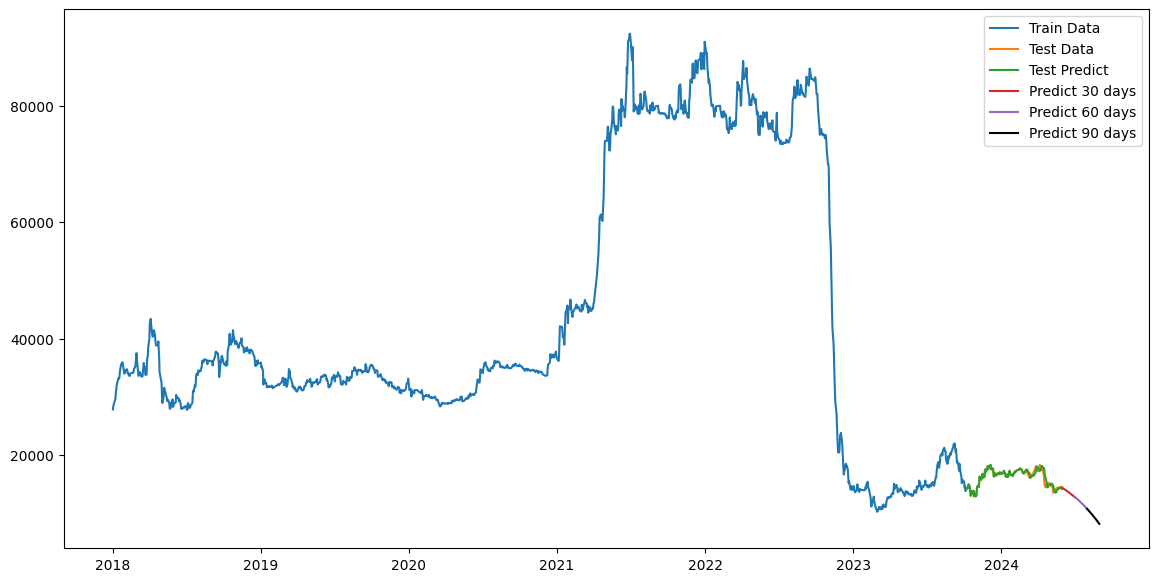

In [20]:
# Plot results
plt.figure(figsize=(14, 7))

# Plot train data
plt.plot(df['Date'][:train_size], scaler.inverse_transform(train_data), label='Train Data')

# Plot test data
plt.plot(df['Date'][train_size:], scaler.inverse_transform(test_data), label='Test Data')

# Plot test predict data with appended last 100 test data
plt.plot(df['Date'][train_size:train_size + len(y_pred_with_test_data)], y_pred_with_test_data, label='Test Predict')

# Plot future predictions
last_test_date = df['Date'].iloc[-1]
future_predict_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=30)
future_predict_dates_1 = pd.date_range(start=last_test_date + pd.Timedelta(days=31), periods=31)
future_predict_dates_2 = pd.date_range(start=last_test_date + pd.Timedelta(days=61), periods=31)

plt.plot(future_predict_dates, future_predict[0:30], label='Predict 30 days')
plt.plot(future_predict_dates_1, future_predict[29:60], label='Predict 60 days')
plt.plot(future_predict_dates_2, future_predict[59:90], label='Predict 90 days', color='black')
# Display the legend
plt.legend()

# Display the plot
plt.show()